# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [39]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [40]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.model_selection import train_test_split, KFold

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')
# For Alice because she keeps her data in a different place :|
# tracks = utils.load('/Volumes/GENRE_DATA/fma_metadata/tracks.csv')
# genres = utils.load('/Volumes/GENRE_DATA/fma_metadata/genres.csv')
# features = utils.load('/Volumes/GENRE_DATA/fma_metadata/features.csv')
# echonest = utils.load('/Volumes/GENRE_DATA/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [4]:
AUDIO_DIR = "data/fma_small"
#For alice
# AUDIO_DIR = "/Volumes/GENRE_DATA/fma_small"

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [5]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [6]:
small = tracks[tracks['set', 'subset'] <= 'small']
small.shape

(8000, 52)

In [7]:
small['track'].groupby('genre_top').size()


genre_top
Blues                     0
Classical                 0
Country                   0
Easy Listening            0
Electronic             1000
Experimental           1000
Folk                   1000
Hip-Hop                1000
Instrumental           1000
International          1000
Jazz                      0
Old-Time / Historic       0
Pop                    1000
Rock                   1000
Soul-RnB                  0
Spoken                    0
dtype: int64

In [8]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(25000, 52)

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [9]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


In [10]:
genres.sort_values('#tracks').head(10)

,#tracks,parent,title,top_level
genre_id,,,,
175,0,86,Bollywood,2
178,0,4,Be-Bop,4
377,1,19,Deep Funk,14
173,4,86,N. Indian Traditional,2
493,4,651,Western Swing,9
374,9,20,Banter,20
808,12,46,Salsa,2
174,17,86,South Indian Traditional,2
465,18,20,Musical Theater,20


## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [12]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [13]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


,album_date,album_name,artist_latitude,artist_location,artist_longitude,artist_name,release
track_id,,,,,,,
2,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
3,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
5,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life
10,2008-03-11,Constant Hitmaker,39.9523,"Philadelphia, PA, US",-75.1624,Kurt Vile,Constant Hitmaker
134,NaN,NaN,32.6783,"Georgia, US",-83.2230,AWOL,AWOL - A Way Of Life


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


,artist_discovery,artist_familiarity,artist_hotttnesss,song_currency,song_hotttnesss
track_id,,,,,
2,0.388990,0.386740,0.406370,0.000000,0.000000
3,0.388990,0.386740,0.406370,0.000000,0.000000
5,0.388990,0.386740,0.406370,0.000000,0.000000
10,0.557339,0.614272,0.798387,0.005158,0.354516
134,0.388990,0.386740,0.406370,0.000000,0.000000


,artist_discovery_rank,artist_familiarity_rank,artist_hotttnesss_rank,song_currency_rank,song_hotttnesss_rank
track_id,,,,,
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
10,2635.0,2544.0,397.0,115691.0,67609.0
134,NaN,NaN,NaN,NaN,NaN


,000,001,002,003,004,005,006,007,008,009,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
2,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
3,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
5,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
10,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
134,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,0.428946,0.446736,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


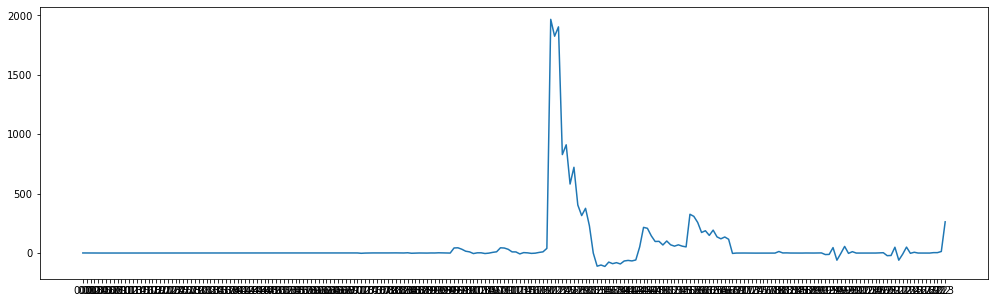

In [14]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

((2000, 2), (2000,))

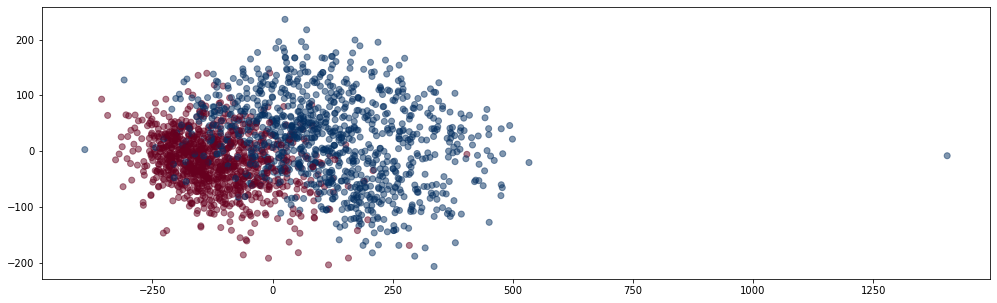

In [15]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [6]:
## START BHAVNA SECTION
## FIX HOW WE ARE GETTING DATA!!! AXIS X IS TIME AND AXIS Y IS FREQUENCY SO DO NOT CUT OFF Y ANYMORE


In [7]:
small = tracks[tracks['set', 'subset'] <= 'small']
small = small.sample(frac=1)
small

album                                                      \
         comments        date_created date_released          engineer   
track_id                                                                
50283           0 2011-07-05 09:53:35           NaT               NaN   
99095           0 2014-02-13 12:01:50    2014-02-11               NaN   
133772          0 2016-03-06 04:49:06           NaT               NaN   
25055           0 2010-02-09 19:06:50           NaT               NaN   
55786           0 2011-10-31 16:28:21           NaT               NaN   
119901          0 2015-05-17 16:35:22           NaT               NaN   
132790          0 2016-02-22 14:51:10    2016-03-01               NaN   
88959           0 2013-08-15 17:28:09    2013-08-09               NaN   
123439          0 2015-08-06 18:02:32    2015-08-06        Alex Gross   
84788           0 2013-05-23 14:56:18    2013-05-08    Ernie Indradat   
62005           0 2012-03-10 10:28:41    1996-10-30  William Hellfire   
85593           0 2013-06-11 08:48:54    2013-06-11               NaN   
110263          2 2014-10-28 09:51:55    2015-10-27               NaN   
59660           0 2012-02-01 13:02:52           NaT               NaN   
117666          1 2015-04-09 15:35:42    2015-04-04        Dan Barker   
144475          0 2016-09-30 21:17:40           NaT               NaN   
154303          0 2017-03-05 04:57:38    2017-03-05               NaN   
11242           0 2009-04-22 05:24:40    2007-04-01               NaN   
56800           3 2011-11-28 01:18:46           NaT               NaN   
82628           0 2013-04-12 09:21:02    2013-04-10               NaN   
118738          0 2015-05-04 18:23:28    2008-01-31         Nick Gent   
60874           0 2012-02-20 17:28:09           NaT               NaN   
71248           0 2012-10-17 09:57:46    2012-09-30               NaN   
44851           0 2011-03-02 13:35:46    2010-01-01               NaN   
49068           0 2009-03-31 08:52:30    2007-03-26     Chris Townend   
64860           0 2012-05-16 14:15:14           NaT               NaN   
19192           0 2009-09-25 10:16:40           NaT               NaN   
135220          0 2016-04-13 05:56:46    2015-06-03               NaN   
6855            0 2009-02-26 12:41:38    2008-10-27      Irene Trudel   
134948          0 2016-04-06 18:06:48           NaT               NaN   
...           ...                 ...           ...               ...   
109450          0 2014-10-09 12:50:14    2014-10-09      Irene Trudel   
52446           3 2011-08-12 16:52:16           NaT               NaN   
21859           0 2009-12-04 17:03:21    2009-01-01               NaN   
33415           1 2010-08-01 09:34:26           NaT               NaN   
15543           1 2009-06-25 00:08:58    2009-06-25               NaN   
67334           0 2012-07-05 02:29:40    2009-08-01               NaN   
145458          0 2016-10-27 14:05:21    2016-10-27       Squire Tuck   
13197           0 2009-05-19 08:44:55    2007-12-01               NaN   
91183           0 2013-09-24 12:18:17           NaT               NaN   
91851           1 2013-10-08 09:12:38    2009-09-28               NaN   
13706           3 2009-05-25 11:51:41    2007-02-27               NaN   
120306          0 2015-05-21 17:43:17           NaT               NaN   
87968           0 2013-08-03 00:19:48           NaT               NaN   
62527           0 2010-11-01 12:08:05           NaT               NaN   
10807           0 2009-04-15 14:01:54    2008-01-01               God   
107189          0 2014-07-09 18:36:25    2014-07-10               NaN   
53863           1 2011-09-15 12:33:36    2011-05-24               NaN   
108494          0 2014-08-26 17:51:54    2014-09-01               NaN   
75399           0 2013-01-07 15:29:34    2010-01-28               NaN   
146969          0 2016-11-28 09:40:26    2016-11-27               NaN   
115814          1 2015-02-28 08:42:22           NaT               NaN 

In [138]:
import warnings

audioData = small['track'][['genre_top']].head(400)

def create_standardized_table(input_table):
    input_table['filename'] = input_table.apply(lambda row : utils.get_audio_path(AUDIO_DIR, row.name), axis = 1) 
    input_table['xsr'] = input_table.apply(lambda row: librosa.load(row['filename'], sr=None, mono=True, duration = 30), axis = 1)
    input_table['stft'] = input_table.apply(lambda row: np.abs(librosa.stft(row['xsr'][0], n_fft=2048, hop_length=512)), axis = 1)
    input_table['mel_spect'] = input_table.apply(lambda row: librosa.feature.melspectrogram(sr=row['xsr'][1], S=row['stft']**2), axis = 1)
    input_table['mel_log'] = input_table.apply(lambda row: librosa.amplitude_to_db(row['mel_spect']), axis = 1)
#     input_table['max_frequency'] = input_table.apply(lambda row: row['mel_log'].shape[0], axis = 1)
#     frequency_cutoff = np.percentile(input_table['max_frequency'], 99, interpolation = 'nearest')
#     print(frequency_cutoff)
#     print(input_table['max_frequency'])
#     input_table = input_table[input_table['max_frequency'] <= frequency_cutoff]
#     print("1",input_table.shape, frequency_cutoff)
#     input_table['mel_log_consistent_size'] = input_table.apply(lambda row: row['mel_log'][0:frequency_cutoff, :], axis = 1)
#     print("2",input_table.shape)
    #normalizing so that every song is put in ranges of -1 to 1
    # TODO: Maybe change to just getting mean of every individual song
#     print(input_table.shape)
#     input_table['mel_log_cut_off'] = input_table.apply(lambda row: row["mel_log"][:,:500], axis=1)
#     input_table['mel_log_normalized'] = input_table.apply(lambda row: librosa.util.normalize(row['mel_log_cut_off']), axis = 1)
    input_table["mfcc"] = input_table.apply(lambda row: librosa.feature.mfcc(S=librosa.power_to_db(row["mel_log"]), n_mfcc=20), axis = 1)
    input_table["mfcc_scaled"] = input_table.apply(lambda row: skl.preprocessing.StandardScaler().fit_transform(row["mfcc"]), axis = 1)
    input_table["mfcc_cut_off"] = input_table.apply(lambda row: row["mfcc_scaled"][:, 0:2584], axis = 1)
    input_table["mfcc_shape"] = input_table.apply(lambda row: row["mfcc_cut_off"].shape, axis = 1)
#     print(input_table.shape)
    input_table['mfcc_with_channel'] = input_table.apply(lambda row: np.reshape(row['mfcc_cut_off'], row['mfcc_cut_off'].shape + (1,)), axis = 1)
#     datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization = True)
#     datagen.fit(np.stack(input_table['mel_log_with_channel']))
#     input_table['mel_log_normalized'] = input_table.apply(lambda row: (row['mel_log_with_channel'] - datagen.mean)/datagen.std, axis = 1)

    return input_table
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    audioData = create_standardized_table(audioData)

In [139]:
audioData["mfcc_with_channel"].iloc[0].shape

(20, 2584, 1)

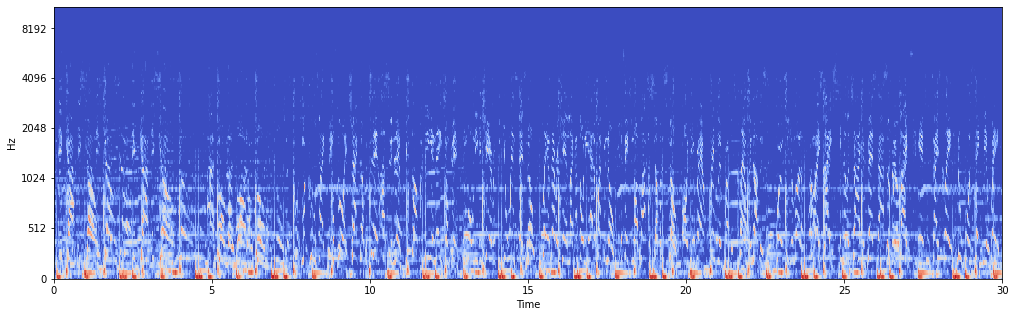

In [113]:
test = audioData.iloc[1]
librosa.display.specshow(test["mel_log"], sr=test["xsr"][1], hop_length=512, x_axis='time', y_axis='mel');

(20, 2584)

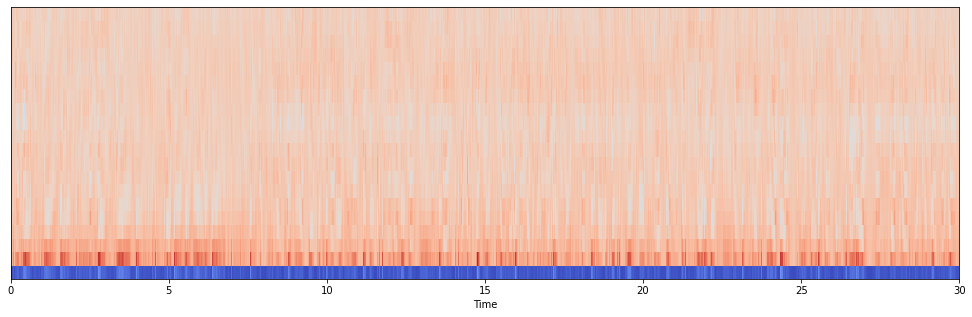

In [114]:
librosa.display.specshow(test["mfcc_scaled"], sr=test["xsr"][1], x_axis='time');
test["mfcc_scaled"].shape

In [144]:
#train test split
X_train, X_test, Y_train, Y_test = train_test_split(audioData.drop('genre_top', inplace=False, axis = 1), audioData['genre_top'], test_size=0.25, random_state=24)

In [145]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=24)

In [147]:
X_test.iloc[0].shape

(10,)

In [17]:
##NOT BEING USED
model = models.Sequential()
model.add(layers.Conv2D(120, (4,4), activation='relu', padding = 'same', input_shape=(10, frequency_cutoff, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=0.1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=0.1)))
model.add(layers.Dense(8, use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=0.1)))
model.summary()

NameError: name 'frequency_cutoff' is not defined

In [162]:
model = models.Sequential()
model.add(layers.Conv2D(300, (2,2), activation='relu', padding = 'same', input_shape=(20, 2584, 1), kernel_regularizer =tf.keras.regularizers.l2( l=.15)))
model.add(layers.Dropout(.4))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(200, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=.15)))
model.add(layers.Dropout(.3))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', use_bias = True))
model.add(layers.Dense(8, use_bias = True))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 20, 2584, 300)     1500      
_________________________________________________________________
dropout_36 (Dropout)         (None, 20, 2584, 300)     0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 10, 1292, 300)     0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 8, 1290, 200)      540200    
_________________________________________________________________
dropout_37 (Dropout)         (None, 8, 1290, 200)      0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2064000)           0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)              

In [151]:
label_dict = {
 'Electronic': 0,
 'Experimental': 1,
 'Folk': 2,
 'Hip-Hop': 3,
 'Instrumental': 4,
 'International': 5,
 'Pop': 6,
 'Rock': 7
}
Y_train = Y_train.replace(label_dict)
Y_val = Y_val.replace(label_dict)
Y_test = Y_test.replace(label_dict)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [156]:
Y_train, Y_val

(track_id
 193     2
 7383    1
 9511    7
 4091    5
 459     7
 3273    2
 4102    5
 995     1
 3263    2
 8345    1
 1427    7
 6675    1
 4096    5
 6857    2
 6609    3
 1687    5
 6332    5
 4013    2
 7711    2
 1680    5
 7375    1
 3707    2
 6342    5
 3534    6
 5       3
 7481    3
 6443    3
 6467    2
 1673    1
 6330    5
        ..
 213     6
 3777    5
 1661    6
 6372    5
 8363    1
 197     2
 6608    3
 7495    7
 9155    1
 3265    2
 676     3
 4782    7
 3778    5
 8357    1
 3905    2
 7376    1
 625     2
 3906    2
 853     5
 534     2
 1039    7
 890     2
 7391    1
 4075    5
 6368    5
 695     3
 3779    5
 4519    0
 4522    0
 704     5
 Name: genre_top, Length: 150, dtype: int64,
 track_id
 822     6
 6367    5
 7492    3
 5376    2
 2097    2
 1733    1
 5171    2
 1443    1
 1544    2
 6440    3
 6331    5
 6329    5
 574     7
 200     2
 6607    3
 4074    5
 1683    5
 3573    0
 3533    6
 6379    5
 4520    0
 8261    2
 708     5
 1197    2


In [157]:
np.stack(X_train["mfcc_with_channel"]).shape

(150, 20, 2584, 1)

In [158]:
#cross validation to find best regularization parameters 
## NOT CURRENTLY USED
fold_no = 1
k_fold = KFold(n_splits=15)
for train_indices, test_indices in k_fold.split(X_train):
    reg_param = 0.00015 * fold_no
    model = models.Sequential()
    model.add(layers.Conv2D(120, (4,4), activation='relu', padding = 'same', input_shape=(10, frequency_cutoff, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',  use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
    model.add(layers.Dense(8, use_bias = True, kernel_regularizer =tf.keras.regularizers.l2( l=reg_param)))
    model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    history = model.fit(np.stack(X_train.iloc[train_indices]['mel_log_with_channel']), np.asarray(Y_train.iloc[train_indices]), epochs=5)
    scores = model.evaluate(np.stack(X_train.iloc[test_indices]['mel_log_with_channel']), np.asarray(Y_train.iloc[test_indices]), verbose=0)
    print(f'Score for fold {fold_no} with reg_param {reg_param}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    fold_no = fold_no + 1


NameError: name 'frequency_cutoff' is not defined

In [ ]:
model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(np.stack(X_train['mfcc_with_channel']), np.asarray(Y_train), batch_size = 40, epochs=40, 
                validation_data=(np.stack(X_val['mfcc_with_channel']), np.asarray(Y_val)))

Train on 150 samples, validate on 150 samples
Epoch 1/40
150/150 [==============================] - 344s 2s/sample - loss: 55.3868 - acc: 0.2333 - val_loss: 34.3336 - val_acc: 0.2467
Epoch 2/40
150/150 [==============================] - 337s 2s/sample - loss: 33.6789 - acc: 0.2733 - val_loss: 32.4209 - val_acc: 0.2600
Epoch 3/40
150/150 [==============================] - 343s 2s/sample - loss: 31.6215 - acc: 0.3400 - val_loss: 30.1088 - val_acc: 0.2933
Epoch 4/40
150/150 [==============================] - 319s 2s/sample - loss: 29.4969 - acc: 0.3533 - val_loss: 27.9944 - val_acc: 0.2800
Epoch 5/40
150/150 [==============================] - 341s 2s/sample - loss: 27.1342 - acc: 0.3933 - val_loss: 25.8235 - val_acc: 0.3200
Epoch 6/40
150/150 [==============================] - 360s 2s/sample - loss: 25.0937 - acc: 0.3867 - val_loss: 23.8923 - val_acc: 0.3267
Epoch 7/40
150/150 [==============================] - 399s 3s/sample - loss: 23.0811 - acc: 0.4467 - val_loss: 22.0608 - val_acc: 0.

In [91]:
Y_val.value_counts()[2]/len(Y_val)

0.2631578947368421

In [80]:
#see which ones it's predicting wrong
val_predictions = model.predict(np.stack(X_val['mfcc_with_channel']))
predictions = []
two_count = 0
for arr in val_predictions:
    predictions.append(np.argmax(arr))
predictions

[5,
 2,
 5,
 2,
 5,
 5,
 2,
 7,
 1,
 1,
 2,
 2,
 7,
 2,
 1,
 1,
 7,
 5,
 2,
 2,
 1,
 5,
 1,
 7,
 5,
 5,
 7,
 1,
 1,
 1,
 2,
 2,
 1,
 5,
 2,
 2,
 5,
 6]

In [81]:
correctness_arr = [0, 0, 0, 0, 0, 0, 0, 0]
for x in range(0, len(predictions)):
    if predictions[x] == Y_val.iloc[x]:
        correctness_arr[predictions[x]] += 1
for y in range(0, 8):
    if y in Y_val.value_counts():
        correctness_arr[y] = str(correctness_arr[y]) + "/" + str(Y_val.value_counts()[y])
    
correctness_arr
    

[0, '1/6', '5/10', '0/1', 0, '3/5', '0/4', '3/12']

In [125]:
## DONE WITH BHAVNA SECTION

In [127]:
filename = utils.get_audio_path(AUDIO_DIR, 10)
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: data/fma_small/000/000010.mp3


/Users/bhavnasud/.local/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


Duration: 29.99s, 1322496 samples


And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

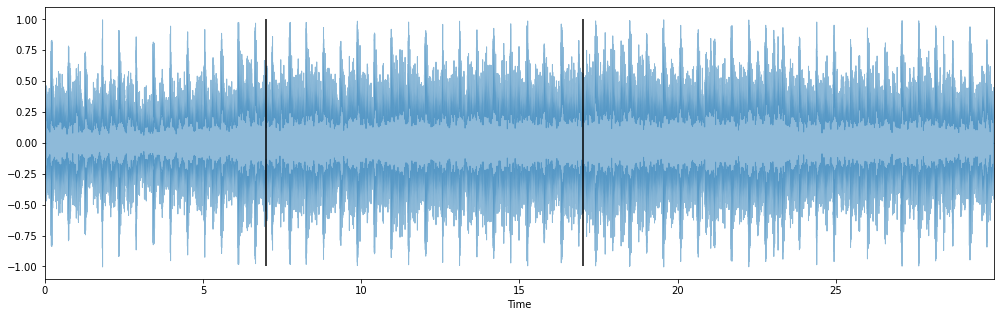

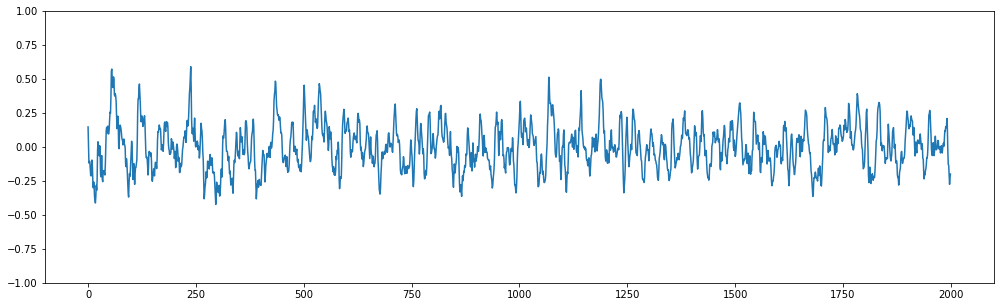

In [20]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

In [12]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

NameError: name 'x' is not defined

In [11]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

NameError: name 'mel' is not defined

## 5 Genre classification

### 5.1 From features

In [17]:
small = tracks['set', 'subset'] <= 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [18]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


### 5.2 From audio